<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:20px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center>
<h1> 📈📉 Sales Prediction 📊📏</h1>
</center>
</div>

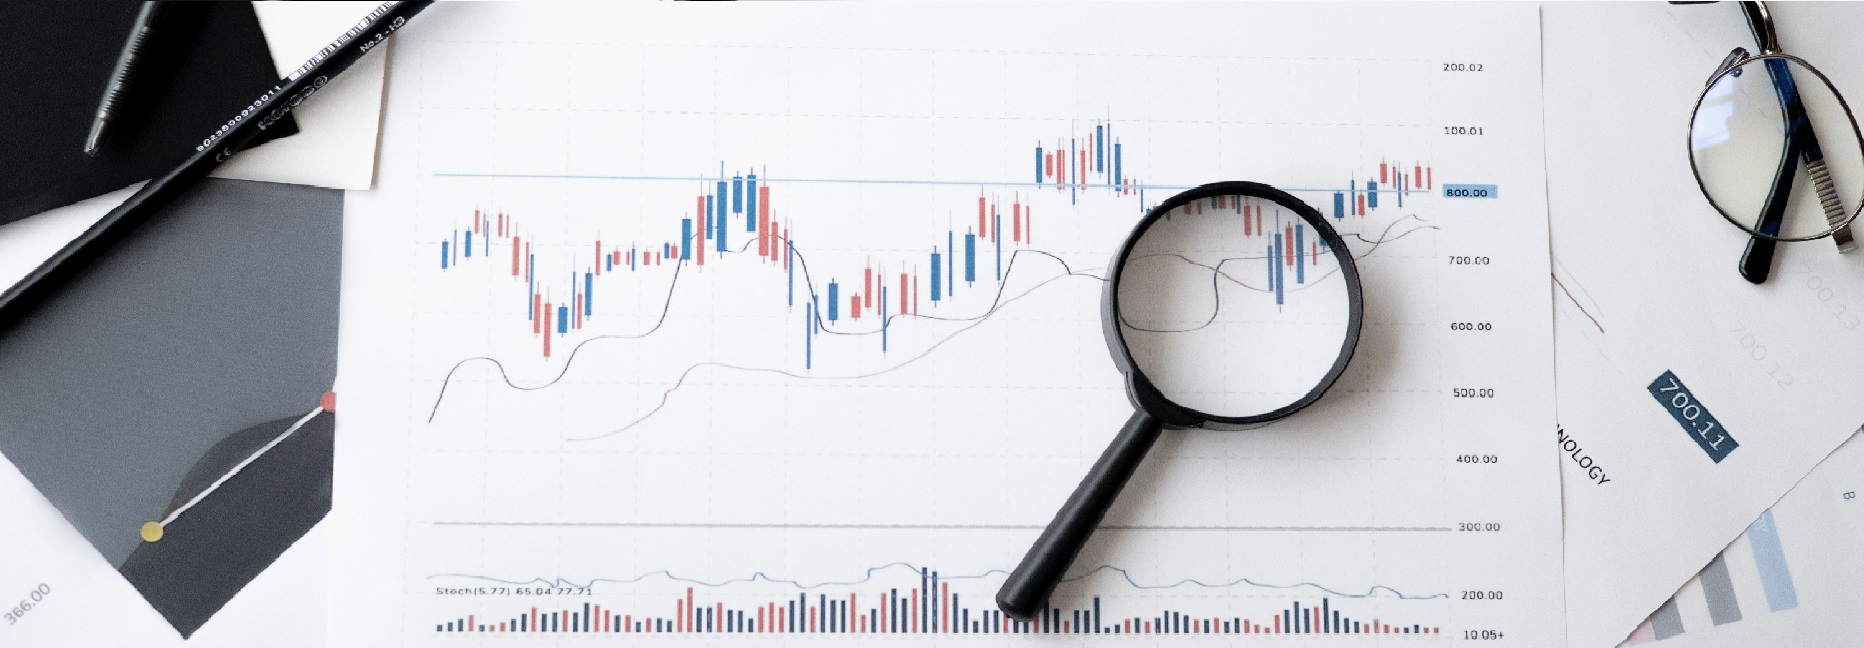

In [ ]:
import numpy as np 
import pandas as pd 
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as md
from multiprocessing import  Pool
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold, KFold, cross_val_score, ShuffleSplit
import xgboost as xgb
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import math

## Table of Content
* [1. EDA](#1.)
    - [1.1 First Look](#1.1)
    - [1.2 Item Categories](#1.2)
    - [1.3 Overall Sales per Month](#1.3)
    - [1.4 Shop Analysis](#1.4)
* [2. Data Preparation](#2.)
    - [2.1 Data Cleaning, Merging and Grouping by Month2.1 Data Cleaning, Merging and Grouping by Month](#2.1)
    - [2.2 Feature Engeneering](#2.2)
        * [2.2.1 Add City Feature](#2.2.1)
        * [2.2.2 Shop Clustering with PCA](#2.2.2)
        * [2.2.3 Item Category Clustering with PCA](#2.2.3)
        * [2.2.4 Adding Lag Features and Label](#2.2.4)
        * [2.2.5 Pipeline Function](#2.2.5)
* [3. Modeling](#3.)
    - [3.1 Submission](#3.1)
    - [3.2 Next Steps](#3.3)

<a id="1."></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h1>📄🔍📊 1. EDA 📜 🔬🧾 </h1> </center>
<hr>   
    
<h3> Data Informations: </h3>
    
Let's first look at the different data files and their features.   
We have four different files for training and one file for submissions.   
For a better understanding of the relationships between the files, I will highlight the keys (the key structure) that connect these files.
    
<hr>
 
<h4> items.csv </h4>
<ul>
<li> item_name - name of item </li>
<li> <b> <span style="color:red;"> item_id </span> </b> - unique identifier of a product </li>
<li> <b> <span style="color:purple;"> item_category_id </span> </b> - unique identifier of item category </li>
</ul> 

<hr>
    
<h4> item_categories.csv </h4>   
<ul>
<li> item_category_name - name of item category </li>
<li> <b> <span style="color:purple;"> item_category_id </span> </b> - unique identifier of item category </li>  
</ul>
    
<hr> 

<h4> shops.csv </h4>
<ul>
<li> <b> <span style="color:green;"> shop_id </span> </b> - unique identifier of a shop </li>   
<li> shop_name - name of shop </li>  
</ul>

<hr>
    
<h4> sales_train.csv </h4>
<ul>
<li> date - date in format dd/mm/yyyy </li>
<li> date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33 </li>  
<li> <b> <span style="color:green;"> shop_id </span> </b> - unique identifier of a shop </li>
<li> <b> <span style="color:red;"> item_id </span> </b> - unique identifier of a product </li>   
<li> item_price - current price of an item </li>
<li> item_cnt_day - number of products sold. You are predicting a monthly amount of this measure </li>
</ul>


<hr>

<h4> test.csv </h4>
<ul>   
<li> ID - an Id that represents a (Shop, Item) tuple within the test set </li>
<li> <b> <span style="color:green;"> shop_id </span> </b> - unique identifier of a shop </li>
<li> <b> <span style="color:red;"> item_id </span> </b> - unique identifier of a product </li>
</ul>  

</div>

In [ ]:
# loading data:
PATH = "/kaggle/input/competitive-data-science-predict-future-sales/"
items_df = pd.read_csv(PATH + "items.csv")
item_categories_df = pd.read_csv(PATH + "item_categories.csv")
shops_df = pd.read_csv(PATH + "shops.csv")
train_df = pd.read_csv(PATH + "sales_train.csv")
test_df = pd.read_csv(PATH + "test.csv")

<a id="1.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h2>🔍👀 1.1 First Look: 👀🔎</h2> </center>
</div>

In [ ]:
items_df.head(2)

In [ ]:
item_categories_df.head(2)

In [ ]:
shops_df.head(2)

In [ ]:
train_df.head(3)

In [ ]:
train_df.tail(3)

In [ ]:
test_df.head(3)

In [ ]:
train_df.isnull().sum()

In [ ]:
"""
Before we change anything in the original Dataframe, we create a copy:

Tip: This is always a good idea.
"""

eda_df = train_df.copy()
eda_df["date"]=  pd.to_datetime(eda_df["date"], format='%d.%m.%Y')
eda_df.sort_values(by="date", ascending=True, inplace=True)
print(eda_df["date"].min())
print(eda_df["date"].max())

In [ ]:
eda_df.tail(3)

In [ ]:
train_df.describe()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> Judging by the mean and maximum values of item_price and item_cnt_day, there are some outliers. <br> We need to keep this in mind and will exclude them for our first visualisations.
</div>

In [ ]:
train_df.info()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
🤔❔ <b> Question: </b> How many shops and products do we have?
</div>

In [ ]:
train_df.nunique()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> So we have 21807 different items and 60 different shops in our train_df.
The instructions say that the number of shops varies over the years. We should take a closer look at that.
<hr>
    
But first, we will look at the number of shops and items in the test_df.
</div>

In [ ]:
test_df.nunique()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> The number of shops and articles is significantly lower. This could be a problem, since we
need to predict the sales figures given a shop_id and an item_id.

<hr>
    
🤔❔ <b> Question: </b> Can we find all shops and items from the test_df also in our train_df?  

In [ ]:
"""
This takes quite a long time, so I just copied the numbers and left the code for you to see.

Tip: This should go much faster if we combine both data frames and then operate in one data frame. (Try it out using the pd.DataFrame.merge operation ☜(ﾟヮﾟ☜) )
You will find an example of this in this notebook.
"""

# missing_shops = [s for s in test_df["shop_id"].unique() if s not in train_df["shop_id"].unique()]
# missing_items = [i for i in test_df["item_id"].unique() if i not in train_df["item_id"].unique()]
# missing_shops_test = [s for s in train_df["shop_id"].unique() if s not in test_df["shop_id"].unique()]
# missing_items_test = [i for i in train_df["item_id"].unique() if i not in test_df["item_id"].unique()]
print(45*"*")
print(f"Number of missing shops in train_df: {0}")
print(f"Number of missing items in train_df: {363}")
print(f"Number of missing shops in test_df: {18}")
print(f"Number of missing items in test_df: {17070}")
print(45*"*")

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<h3>📝 What have we got so far? 📝</h3>
<hr>
<ul>
<li>We have 60 shops in our training dataset and 42 shops in our test dataset. </li>
<li> We have 21807 distinct items in our training dataset and 5100 distinct items in our test dataset. </li>
<li> All the shops in our test dataset are also in our training dataset. </li>
<li> 362 items in our test dataset are not included in our train_df</li>.
    <ul>
    <li>This also means that we do not have the price for these items. </li>
    </ul>
</ul>
<h3>What is our target? </h3>
<hr>
<ul>
<li>We want to predict the number of items sold for November 2015. </li> 
    <ul>
    <li> More specifically, we want to predict the number of items sold for each of the 5100 items in our test_df and for each shop that sells these items.🤯
    <li> So we have 214200 different rows (pairs of shop_id and item_id represented by the ID) that need to be predicted. 
    <li> Furthermore, 363 elements are not represented in our train_df. Here we may have to use the category to make some predictions.
    </ul>
</ul>
Let's go ahead and take a closer look at the items. There was a hint in the project description that some items are returend. So maybe they have item_cnt_day < 0?

</div>

In [ ]:
len(eda_df[eda_df["item_cnt_day"]<0])

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> These must be the returned items. Since we want to predict the number of items sold, we should ignore these entries.

<hr>
    
🤔❔ <b> Question: </b> Are there also items with item_cnt = 0? 

These should then be products that were bought and returned on the same day. (An entry is only made in the data record when a product is purchased. And the number is aggregated on a daily basis, so this could be possible).
</div>

In [ ]:
len(eda_df[eda_df["item_cnt_day"]==0])

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
This is not the case. Let's omit all entries with item_cnt_day < 0 and map outliers for our first visuals.

In [ ]:
eda_df["item_cnt_day"] = eda_df["item_cnt_day"].map(lambda x: 0 if x<0 else x)
# Check:
len(eda_df[eda_df["item_cnt_day"]<0])

In [ ]:
"""
We will map the top 5% for "item_price" and "item_cnt_day" to the top qualtile value for the following plots. 
(We have seen before that there are some outliers)
"""
for col in ["item_price", "item_cnt_day"]:
    upper_quantile = eda_df[col].quantile(0.95)
    eda_df[col] = np.where(eda_df[col]>upper_quantile, upper_quantile,eda_df[col])

"""
Furthermore, let us create a column for the actual turnover per item.
"""
eda_df["sales_per_item"] = eda_df["item_price"] * eda_df["item_cnt_day"]

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
💡 <b> Tip: </b> Defining a general style at the beginning of your notebook will give all your plots a consistent look. I use seaborn as the plotting library in this notebook. Since this library is completely based on matplotlib, the same procedure is also possible using matplotlib.

So let's do that first.

In [ ]:
"""
Let's start with a general colour setting:
"""
sns.set(rc={'axes.facecolor':"#F8F9F9",
            "figure.facecolor":"#CACFD2",
            "grid.color":"#E5E7E9",
            "axes.edgecolor":"#17202A",
            "axes.labelcolor":"#17202A",
            "text.color":"#17202A"
           }) 
"""
Change the axis label size: (We will set the other sizes individually).
"""
sns.set_context(rc={"axes.labelsize" : 20})

In [ ]:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax02.tick_params(axis='both', labelsize=15)
ax00.set_title('Sales per item per day', fontsize=20)
ax01.set_title('Item price distribution', fontsize=20)
ax02.set_title('Item count distribution', fontsize=20)
sns.histplot(data = eda_df ,x="sales_per_item", kde=True, bins=50, ax=ax00, color="violet")
sns.histplot(data = eda_df ,x="item_price", kde=True, bins=50, ax=ax01, color="tomato")
sns.histplot(data = eda_df ,x="item_cnt_day", kde=False, bins=10, ax=ax02, color="cornflowerblue")

fig.subplots_adjust(top=0.8)
fig.suptitle('Sales Feature Distributions per Day', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<h3> 📝 Notes: </h3>
<hr>
<ul>
<li>We are looking at the salse figures on a daily basis. </li>
<li>So the item count distribution does not represent our target distribution. </li>
    <ul>
    <li>As already mentioned the records do not contain an entry for an item that was not purchased on a specific date. </li>
    </ul>
<li> But we get an idea of the price range (excluding the top 5%) and it should be noted that most items, when sold, are sold once a day and rarely more than once.</li>
</ul>
I assume that the prices of the individual items are not the same for every shop and every month. Let's take a quick look at some items within the same price range to verify our assumption.
</div>

In [ ]:
eda_df

In [ ]:
fig, ax =  plt.subplots(figsize=(25,5))
ax.tick_params(axis='both', labelsize=15)
ax.set_title('Item Price Development', fontsize=20)
prict_df = eda_df[(eda_df["item_price"] < 500) & (eda_df["item_price"] > 100)].copy()

for i in prict_df["item_id"].unique()[50:60]:
    tmp_df = prict_df[prict_df["item_id"]==i].copy()
    sns.lineplot(x="date_block_num", y="item_price", data=tmp_df, palette="Set2", ax=ax)

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<h3> 📝 Notes: </h3>
<hr>
<ul>
<li> As we can see, the price for each item changes per month and is not the same for each shop. (This is indicated by the spaces around the lines for some months) </li>
<li> The price can change in both directions. </li>
</ul>
Let's go further and take a closer look at the different item categories.
</div>

<a id="1.2"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h2> 1.2 Item Categories  🧴🧹🎁🥼💍 </h2> </center>
    
<hr>
    
🤔❔ <b> Question: </b> How many different categories do we have? 
</div>

In [ ]:
item_categories_df.nunique()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> So we have 85 different item categories. Let's include them in our eda_df and see if we can identify some seasonal trends.
</div>

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left"> 
💡 <b> Tip: </b> If you want to combine several data frames or simply do something like a join in SQL,
you should use the pandas.merge method for performance reasons. You could also use df.map(lambda x: ...), but this is 
not advisable if the data set has a certain size.
</div>

In [ ]:
"""
Don`t do it like this:
"""
#eda_df["item_category"] = eda_df["item_id"].map(lambda x : items_df[items_df["item_id"]==x]["item_category_id"].values[0])
"""
Do it like this:
"""
eda_df = pd.merge(eda_df, items_df, on='item_id', how='inner')
eda_df = pd.merge(eda_df, item_categories_df, on='item_category_id', how='inner')
eda_df.head()

<a id="1.2"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
    
🤔❔ <b> Question: </b> Are there items that are in more than one category?
</div>

In [ ]:
"""
So how can we answer this question with pandas? 

In SQL you would do something like 

SELECT item_id, countd(item_category_id)
FROM eda_table 
GROUP BY item_id 
HAVING countd(item_category_id) > 0;

Let's do the same thing. We group by item_id and count the number of distinct category_ids. 
We save this information an a new dataframe and then check if we have entries with more then one item_catgory_id
"""
unique_item_to_cat_df = eda_df[["item_id", "item_category_id"]].groupby(["item_id"]).nunique("item_category_id")
len(unique_item_to_cat_df[unique_item_to_cat_df["item_category_id"] > 1])

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> Good. All items are in exactly one category. One less thing to worry about.
    
<hr>
   
Predicting sales for each of these categories will be challenging. Let's see how many categories are included in our test_df.
</div>

In [ ]:
eda_test_df = test_df.copy()
eda_test_df = pd.merge(eda_test_df, items_df, on="item_id", how="inner")
print(f"Number of unique item categories in test_df: {eda_test_df.item_category_id.nunique()}")

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> There are still 62 different categories and we still know very little about them. So let's create a data framework with some more information about these categories. Maybe we can summarise some of them. For better readability, we will create a data frame where each category is represented in one line. For later visualisations we can change the structure a bit. 
</div>

In [ ]:
item_category_info_df = pd.DataFrame(
    columns=["name", "num_products", "first_sold", "last_sold", "min_price", "max_price", "mean_price", "median_price",
              "mean_item_cnt_month", "median_item_cnt_month", "mean_cnt_jan", "mean_cnt_feb", "mean_cnt_mar", "mean_cnt_apr",
              "mean_cnt_may", "mean_cnt_jun", "mean_cnt_jul", "mean_cnt_aug", "mean_cnt_sep", "mean_cnt_oct", "mean_cnt_nov", "mean_cnt_dez"],
    index = item_categories_df["item_category_id"].unique())

for cid in item_category_info_df.index:
    item_category_info_df.at[cid, "name"] = item_categories_df[item_categories_df["item_category_id"]==cid]["item_category_name"].values
    item_category_info_df.at[cid, "num_products"] = items_df[items_df["item_category_id"]==cid]["item_id"].nunique()
    cdf= eda_df[eda_df["item_category_id"]==cid].copy()
    item_category_info_df.at[cid, "first_sold"] = cdf["date"].min()
    item_category_info_df.at[cid, "last_sold"] = cdf["date"].max()
    item_category_info_df.at[cid, "min_price"] = cdf["item_price"].min()
    item_category_info_df.at[cid, "max_price"] = cdf["item_price"].max()
    item_category_info_df.at[cid, "mean_price"] = cdf["item_price"].mean()
    item_category_info_df.at[cid, "median_price"] = cdf["item_price"].median()
    """
    The following part is a little tricky. We first change the date feature to the first of each month so that each date in a month is mapped to the first day of the month.
    Then we group by this new date. We then get a dataframe with the values sum_sales and sum_item_cnt for each month in each year.
    As a final step, we group by month to get the mean value for each month. I hope I didn't mess it up, it's getting late ¯\_(ツ)_/¯. If you have any suggestions on how to achieve the same
    result with less effort, let me know in the comments section.
    """
    # ------------------------------------------------------------------------------------------------------
    cdf["month"] = cdf["date"].dt.month
    cdf["year"] = cdf["date"].dt.year
    cdf["date"] = pd.to_datetime(cdf[["year", "month"]].assign(DAY=1))
    cdf = cdf[["date", "item_cnt_day", "sales_per_item"]].groupby("date").sum().reset_index()
    cdf = cdf[["date", "item_cnt_day", "sales_per_item"]].groupby(cdf["date"].dt.month).mean().reset_index()
    cdf.rename(columns ={"item_cnt_day": "item_cnt_month", "sales_per_item": "sales_per_month"}, inplace=True)
    # ------------------------------------------------------------------------------------------------------
    item_category_info_df.at[cid, "mean_item_cnt_month"] = cdf["item_cnt_month"].mean()
    item_category_info_df.at[cid, "median_item_cnt_month"] = cdf["item_cnt_month"].median()
    """
    If we now want to have the average number of items sold per month, we have to take into account that not all item categories are sold every month.
    """
    month_mapping = {1: "mean_cnt_jan", 2: "mean_cnt_feb", 3: "mean_cnt_mar", 4: "mean_cnt_apr", 5: "mean_cnt_may", 6: "mean_cnt_jun",
              7: "mean_cnt_jul", 8: "mean_cnt_aug", 9: "mean_cnt_sep", 10: "mean_cnt_oct", 11: "mean_cnt_nov", 12: "mean_cnt_dez"}
    for m in cdf["date"].unique():
        item_category_info_df.at[cid, month_mapping[m]] = cdf[cdf["date"]==m]["item_cnt_month"].values[0]  # we could also do cdf.iloc[m-1] but i found this more readable.

In [ ]:
item_category_info_df

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
    
📝 <b> Note: </b> Each line contains information about a product group and we could also use this dataframe to find some groups of categories. 
Let's dig into it a bit to get a better understanding of how these item categories differ from each other.
Let's start with the characteristics first_sold and last_sold. 
<hr>
🤔❔ <b> Question: </b> Are there some item categories that disappeared between 2013 and 2015? 
</div>

In [ ]:
fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1, 2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax00.set_title('first_sold distribution', fontsize=20)
ax01.set_title('last_sold distribution', fontsize=20)
sns.histplot(data = item_category_info_df ,x="first_sold", bins=50, ax=ax00).set(xlabel=None)
sns.histplot(data = item_category_info_df ,x="last_sold", bins=50, ax=ax01).set(xlabel=None)
fig.subplots_adjust(top=0.82)
fig.suptitle('Date Feature Distribution', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> As we can see, most element categories start at the beginning of our timeline (or before) and last until the end. But there are a few exceptions. For example, new item categories evolve and some of them had their last sold item in 2013. Nothing surprising, but good to know. Let's take a closer look at the min, max, median and mean values.
</div>

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left"> 
💡 <b> Tip: </b> If you want to look at the distribution of certain columns in your data frame, perhaps even categorised by a certain characteristic, you can use seaborn.distplot(). However, I prefer to create each plot from scratch to have more control. The code might be a bit repetitive, so I will hide it. Take a look if you are interested.
</div>

In [ ]:
fig = plt.figure(figsize=(25,15))
gs = fig.add_gridspec(3, 2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1])
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax10.tick_params(axis='both', labelsize=15)
ax11.tick_params(axis='both', labelsize=15)
ax20.tick_params(axis='both', labelsize=15)
ax21.tick_params(axis='both', labelsize=15)
ax00.set_title('mean_item_cnt_month distribution', fontsize=20)
ax01.set_title('median_item_cnt_month distribution', fontsize=20)
ax10.set_title('min_price distribution', fontsize=20)
ax11.set_title('max_price distribution', fontsize=20)
ax20.set_title('mean_price distribution', fontsize=20)
ax21.set_title('median_price distribution', fontsize=20)
sns.histplot(data = item_category_info_df ,x="mean_item_cnt_month", bins=100, ax=ax00).set(xlabel=None)
sns.histplot(data = item_category_info_df ,x="median_item_cnt_month", bins=100, ax=ax01).set(xlabel=None)
sns.histplot(data = item_category_info_df ,x="min_price", bins=100, ax=ax10).set(xlabel=None)
sns.histplot(data = item_category_info_df ,x="max_price", bins=100, ax=ax11).set(xlabel=None)
sns.histplot(data = item_category_info_df ,x="mean_price",bins=100, ax=ax20).set(xlabel=None)
sns.histplot(data = item_category_info_df ,x="median_price", bins=100, ax=ax21).set(xlabel=None)
fig.subplots_adjust(top=0.92)
fig.suptitle('Numeric Feature Distribution', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> We can see that most item categories have a wide range of items (price-wise), but the mean and median_price distribution show us that the overall price structure is different. 
What I would like to see is the sales trend (in terms of mean numbers per month) for each item category (as this is our final target for the forecast). But the way we have built our data framework is not really well suited to displaying this.
So let's write some code to solve this homemade issue. We can also reuse this later when we look at sales trends per shop.
</div>

In [ ]:
item_cat_sales_dev_df = pd.DataFrame(columns=["item_cat_id","month", "mean_cnt"])
i = 0
for index, row in item_category_info_df.iterrows():
    for m in month_mapping.keys():
        item_cat_sales_dev_df.at[i, "item_cat_id"] = index
        item_cat_sales_dev_df.at[i, "month"] = m
        item_cat_sales_dev_df.at[i, "mean_cnt"] = row[month_mapping[m]]
        i += 1;
item_cat_sales_dev_df = item_cat_sales_dev_df.astype({"item_cat_id": "int8", "month": "int32", "mean_cnt": "float32"});

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
This is a more suitable data structure for a machine. Now we can represent mean_cnt per month and use the 
seaborn hue parameter on item_cat_id for example. 

<hr>
    
🤔❔ <b> Question: </b> So what does this look like for a single category?

In [ ]:
print("Sales development for categoriy 15:")
item_cat_sales_dev_df[item_cat_sales_dev_df["item_cat_id"]==15]

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left"> 
This looks as expected. Let's plot all the item categories by size and see if we can find some category-specific seasonalities.

In [ ]:
fig = plt.figure(figsize=(25,25))
gs = fig.add_gridspec(3, 2)
ax0x = fig.add_subplot(gs[0,:])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1])
ax0x.tick_params(axis='both', labelsize=15)
ax10.tick_params(axis='both', labelsize=15)
ax11.tick_params(axis='both', labelsize=15)
ax20.tick_params(axis='both', labelsize=15)
ax21.tick_params(axis='both', labelsize=15)
ax0x.set_title('Overall mean item count per month', fontsize=20)
ax10.set_title('Mean item count per month (max count < 100)', fontsize=20)
ax11.set_title('Mean item count per month (100 <= max count < 1000)', fontsize=20)
ax20.set_title('Mean item count per month (1000 <= max count < 5000)', fontsize=20)
ax21.set_title('Mean item count per month (5000 <max count)', fontsize=20)

sns.lineplot(x="month", y="mean_cnt", data=item_cat_sales_dev_df, palette="Set2", ax=ax0x)

"""
Plot each category, depending on its max mean_cnt:
"""

for c in item_cat_sales_dev_df["item_cat_id"].unique():
    tmp_df = item_cat_sales_dev_df[item_cat_sales_dev_df["item_cat_id"]==c].copy()
    max_mean_count = tmp_df["mean_cnt"].max()
    #sns.lineplot(x="month", y="mean_cnt", data=tmp_df, palette="Set2", ax=ax0x)
    if max_mean_count < 100:
        sns.lineplot(x="month", y="mean_cnt", data=tmp_df, palette="Set2", ax=ax10)
    elif 100 <= max_mean_count < 1000 :
        sns.lineplot(x="month", y="mean_cnt", data=tmp_df, palette="Set2", ax=ax11)
    elif 1000 <= max_mean_count < 5000 :
        sns.lineplot(x="month", y="mean_cnt", data=tmp_df, palette="Set2", ax=ax20)
    else: 
        # > 5000
        sns.lineplot(x="month", y="mean_cnt", data=tmp_df, palette="Set2", ax=ax21)          
plt.legend([],[], frameon=False)
fig.subplots_adjust(top=0.94)
fig.suptitle('Turnover Trend for Each Item Category', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> I think we can say that overall we have an increase in sales in november and december. Not all product categories are effective, but most of them. In fact, we can't see much difference in seasonality between categories. This will be very useful to us when we start training a model, as we may train our first model on a category level and we may be able to predict category x when our model has been trained on all the other categories. 

<hr>
    
Let's take a closer look at total sales per month from 2013 - 2015. To do this, we create a new dataframe grouped by month only.
</div>

<a id="1.3"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">   
<center> <h2> 1.3 Overall Sales per Month 🔦📆📊</h2> </center>
<hr>
    
We start by creating a new data frame that shows the total sales per month. This can easily be done with the groupby() function of pandas datafremes.
</div>

In [ ]:
m_df = eda_df.copy()
"""
Fist we need to cast date to datetime and then we can use all the sweet ".dt"-features
""" 
m_df['date']= pd.to_datetime(m_df['date'])
m_df["month"] = m_df["date"].dt.month
m_df["year"] = m_df["date"].dt.year
m_df['date'] = pd.to_datetime(m_df[['year', 'month']].assign(DAY=28)) # workaround for end of month (its just for the visuals so we should be ok here)
m_df = m_df[["date", "item_cnt_day", "sales_per_item"]].groupby("date").sum().reset_index()
m_df.rename(columns ={"item_cnt_day": "item_cnt_month", "sales_per_item": "sales_per_month"}, inplace=True)
m_df

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
Looks good. Let's plot the total sales numbers per month.
</div>

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left"> 
💡 <b> Tip: </b> You can use horizontal and vertical lines to draw attention to a specific section and to show reference values. In addition, you can add arrows and annotations to your chart to provide even more information. Take a close look at the code below if you are interested. And don't hesitate to ask questions in the comments section.
</div>

In [ ]:
fig = plt.figure(figsize=(25,15))
gs = fig.add_gridspec(2, 1)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax0.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax0.set_title('Sales per Month', fontsize=20)
ax1.set_title('Items Sold per Month', fontsize=20)

# adding hrozontal lines
ax0.hlines(y=m_df["sales_per_month"].mean(), color='b', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="MEAN") 
ax0.hlines(y=m_df["sales_per_month"].quantile(0.95), color='g', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="95_QUANTIL") 
ax0.hlines(y=m_df["sales_per_month"].quantile(0.05), color='r', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="05_QUANTIL")
ax1.hlines(y=m_df["item_cnt_month"].mean(), color='b', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="MEAN") 
ax1.hlines(y=m_df["item_cnt_month"].quantile(0.95), color='g', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="95_QUANTIL") 
ax1.hlines(y=m_df["item_cnt_month"].quantile(0.05), color='r', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="05_QUANTIL")

# adding vertical lines
ax0.vlines(x=datetime.strptime("2013-11-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax0.vlines(x=datetime.strptime("2013-12-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax0.vlines(x=datetime.strptime("2014-11-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax0.vlines(x=datetime.strptime("2014-12-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2013-11-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2013-12-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2014-11-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2014-12-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)

# adding some arrows (this can be a bit trickt and frustrating ;) )
style = dict(size=15, color='black')

x_date_1 = md.date2num(datetime.strptime("2013-9-15", "%Y-%m-%d"))
x_date_1_dt = md.date2num(datetime.strptime("2013-11-15", "%Y-%m-%d")) - x_date_1
x_date_2 = md.date2num(datetime.strptime("2014-9-15", "%Y-%m-%d"))
x_date_2_dt = md.date2num(datetime.strptime("2014-11-15", "%Y-%m-%d")) - x_date_2

ax0.arrow(x_date_1, 125000000, x_date_1_dt, -35000000, head_width=10, head_length=5000000, width=3)
ax0.text(x_date_1, 125000000, "November 2013", ha='right', **style)
ax0.arrow(x_date_2, 125000000, x_date_2_dt, -25000000, head_width=10, head_length=5000000, width=3)
ax0.text( x_date_2, 125000000, "November 2014", ha='right', **style)

ax1.arrow(x_date_1, 130000, x_date_1_dt, -20000, head_width=15, head_length=1500, width=3)
ax1.text(x_date_1, 125000, "November 2013", ha='right', **style)
ax1.arrow(x_date_2, 130000, x_date_2_dt, -33000, head_width=15, head_length=1500, width=3)
ax1.text( x_date_2, 125000, "November 2014", ha='right', **style)


sns.lineplot(data=m_df, y="sales_per_month", x = "date", palette="tab10", linewidth=5, ax=ax0, label="sales_per_month")
sns.lineplot(data=m_df, y="item_cnt_month", x = "date", palette="tab10", linewidth=5, ax=ax1, label="item_cnt_month")
fig.subplots_adjust(top=0.915)
fig.suptitle('Sales Numbers per Month', fontsize="28")
plt.legend();

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> As expected, we see the same phenomenon in total sales. 
What we did not see when we focused on average sales per item category is <br> that total sales in 2015 are slightly lower compared to the previous two years. We should keep that in mind.

<hr>
Let's change the perspective a slightly to compare the sales figures of the individual years.
</div>

In [ ]:
m_df[m_df["date"].dt.year == 2013]

In [ ]:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax0.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax0.set_title('Sales per Month', fontsize=20)
ax1.set_title('Items Sold per Month', fontsize=20)
"""
Tip: See how we can use the .dt property since "date" is a datetime column. 
     You can also replace the x-values as described below.
"""
month_ = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
sns.lineplot(data=m_df[m_df["date"].dt.year == 2013], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2013")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2014], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2014")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2015], y="sales_per_month", x=month_[:-2], palette="tab10", linewidth=5, ax=ax0, label="2015")

sns.lineplot(data=m_df[m_df["date"].dt.year == 2013], y="item_cnt_month", x=month_, palette="tab10", linewidth=5, ax=ax1, label="2013")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2014], y="item_cnt_month", x=month_, palette="tab10", linewidth=5, ax=ax1, label="2014")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2015], y="item_cnt_month", x=month_[:-2], palette="tab10", linewidth=5, ax=ax1, label="2015")
fig.subplots_adjust(top=0.8)
fig.suptitle('Sales Numbers per Month', fontsize="28")
ax0.legend()
ax1.legend();

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> 
What we can see is that there is an overall decline in the number of items sold per month, even though the sales figures for 2013 and 214 are quite similar. This means that people tend to buy fewer but more expensive items. Also, we can now see how weak the sales figures for 2015 look compared to the previous two years.
    
<hr>
    
Previously we took a closer look at the individual item categories, let's wrap this section up by taking a closer look at the individual shops. I don't think we will see anything surprising in the sales figures per shop, but it is always advisable to look at the whole dataset before moving on to preprocessing and modelling. 
</div>

<a id="1.4"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h2> 🏠🏦💒 1.4 Shop Analysis 🏩🏪🏬</h2> </center>
</div>

In [ ]:
"""
We do the same as before, but now we also add the shot_id in our groupby-step.

As always, if you have any questions about the code, feel free to ask them in the comments section.
The same goes for suggestions for improvements ofcorse!
"""
m_shop_df = eda_df.copy()

m_shop_df['date']= pd.to_datetime(m_shop_df['date'])
m_shop_df["month"] = m_shop_df["date"].dt.month
m_shop_df["year"] = m_shop_df["date"].dt.year
m_shop_df['date'] = pd.to_datetime(m_shop_df[['year', 'month']].assign(DAY=28)) # workaround for end of month (its just for the visuals so we should be ok here)
m_shop_df = m_shop_df[["date", "item_cnt_day", "sales_per_item", "shop_id"]].groupby(["date", "shop_id"]).sum().reset_index()
m_shop_df.rename(columns ={"item_cnt_day": "item_cnt_month", "sales_per_item": "sales_per_month"}, inplace=True)
m_shop_df

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
Looks as expected. Let's start the inspection with a boxplot for turnover and items sold per month per shop. This should give us an overall impression of the size distribution for the shops.
</div>

In [ ]:
fig = plt.figure(figsize=(25,10))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax0.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax0.set_title('Sale per Month', fontsize=20)
ax1.set_title('Items Sold per Month', fontsize=20)
sns.boxplot(x=m_shop_df["date"].dt.month, y="sales_per_month", data=m_shop_df, ax=ax0, palette="Paired")
sns.boxplot(x=m_shop_df["date"].dt.month, y="item_cnt_month", data=m_shop_df, ax=ax1, palette="Paired")
fig.subplots_adjust(top=0.87)
fig.suptitle('Sales Numbers per Month and Shop', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> As we can see, we have perhaps two handfuls of shops that are much bigger than all the others. (Or we might have something like 10 extremely strong individual months for random shops. However, I think the former is more likely.) For better understanding, we will now create a new data frame with key numbers for each shop. (As we did for the item categories)
</div>

In [ ]:
"""
Create a data dataframe with some basic information about our 60 shops:
"""
shop_info_df = pd.DataFrame(columns=["shop_name", "num_products", "fist_business_m", "last_business_m",
                                     "min_price", "max_price", "mean_price", "median_price", "mean_sales_pm", "median_sales_pm"],
                            index = m_shop_df["shop_id"].unique())

for sid in m_shop_df["shop_id"].unique():
    shop_info_df.at[sid, "shop_name"] = shops_df[shops_df["shop_id"]==sid]["shop_name"].values[0]
    shop_info_df.at[sid, "num_products"] = train_df[train_df["shop_id"]==sid]["item_id"].nunique()
    sdf= m_shop_df[m_shop_df["shop_id"]==sid]
    shop_info_df.at[sid, "fist_business_m"] = sdf["date"].min()
    shop_info_df.at[sid, "last_business_m"] = sdf["date"].max()
    shop_info_df.at[sid, "min_price"] = train_df[train_df["shop_id"]==sid]["item_price"].min()
    shop_info_df.at[sid, "max_price"] = train_df[train_df["shop_id"]==sid]["item_price"].max()
    shop_info_df.at[sid, "mean_price"] = train_df[train_df["shop_id"]==sid]["item_price"].mean()
    shop_info_df.at[sid, "median_price"] = train_df[train_df["shop_id"]==sid]["item_price"].median()
    shop_info_df.at[sid, "mean_sales_pm"] = sdf["sales_per_month"].median()
    shop_info_df.at[sid, "median_sales_pm"] = sdf["sales_per_month"].median()
    """
    We will do it a little bit different for this shop dataframe. Here, the average turnover per month would
    not be so interesting.Instead, we can use our m_shop_df for the sales figures per month.
    """
# changing datatypes from object to datetime float and int:
shop_info_df['fist_business_m']= pd.to_datetime(shop_info_df['fist_business_m'])
shop_info_df['last_business_m']= pd.to_datetime(shop_info_df['last_business_m'])
shop_info_df["fist_business_m"] = shop_info_df["fist_business_m"].dt.strftime("%Y-%m")
shop_info_df["last_business_m"] = shop_info_df["last_business_m"].dt.strftime("%Y-%m")
shop_info_df = shop_info_df.astype({'num_products': 'int32',
                                    "min_price": 'float32',
                                    "max_price": 'float32',
                                    "mean_price": 'float32',
                                    "median_price": 'float32',
                                    "mean_sales_pm": 'float32',
                                    "median_sales_pm": 'float32'})

In [ ]:
shop_info_df.head(5)

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
Looks good. Let's create the same representations as before for our item categories to get a deeper understanding of the overall structure of the shops. Again, starting with the first and last day of business.
</div>

In [ ]:
fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(1, 2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax00.set_title('fist_business_m distribution', fontsize=20)
ax01.set_title('last_business_m distribution', fontsize=20)
ax00.tick_params(labelrotation=45, axis="x")
ax01.tick_params(labelrotation=45, axis="x")
sns.histplot(data = shop_info_df ,x="fist_business_m", bins=15, ax=ax00)
sns.histplot(data = shop_info_df ,x="last_business_m", bins=15, ax=ax01);
fig.subplots_adjust(top=0.8)
fig.suptitle('First and Last Day of Business Distribution', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b>  Similar to the item categories, most shops exist for the entire period, with some exceptions, as we have already seen. Let's now take a closer look at the other shop-specific features.
</div>

In [ ]:
fig = plt.figure(figsize=(25,20))
gs = fig.add_gridspec(4, 2)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1])
ax3 = fig.add_subplot(gs[3,:])
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax10.tick_params(axis='both', labelsize=15)
ax11.tick_params(axis='both', labelsize=15)
ax20.tick_params(axis='both', labelsize=15)
ax21.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', labelsize=15)
ax00.set_title('mean_sales_pm distribution', fontsize=20)
ax01.set_title('median_sales_pm distribution', fontsize=20)
ax10.set_title('min_price distribution', fontsize=20)
ax11.set_title('max_price distribution', fontsize=20)
ax20.set_title('mean_price distribution', fontsize=20)
ax21.set_title('median_price distribution', fontsize=20)
ax3.set_title('num_products distribution', fontsize=20)
sns.histplot(data = shop_info_df ,x="mean_sales_pm", bins=100, ax=ax00).set(xlabel=None)
sns.histplot(data = shop_info_df ,x="median_sales_pm", bins=100, ax=ax01).set(xlabel=None)
sns.histplot(data = shop_info_df ,x="min_price", bins=100, ax=ax10).set(xlabel=None)
sns.histplot(data = shop_info_df ,x="max_price", bins=100, ax=ax11).set(xlabel=None)
sns.histplot(data = shop_info_df ,x="mean_price",bins=100, ax=ax20).set(xlabel=None)
sns.histplot(data = shop_info_df ,x="median_price", bins=100, ax=ax21).set(xlabel=None)
sns.histplot(data = shop_info_df ,x="num_products", bins=50, ax=ax3).set(xlabel=None)
fig.subplots_adjust(top=0.92)
fig.suptitle('Numeric Feature Distribution', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> As we can see, the price range is very wide for most shops, but I am a bit suspicious about the number of shops with min_price close to zero. The rest looks good, mean and average sales are relatively close, which is good. This is not the case for mean and average price. This indicates that the price distribution for individual shops is not normally distributed.
<hr>
<h4> Let's take a closer look at the shops with min_price close to zero. 🔎</h4>
</div>


In [ ]:
shop_info_df[shop_info_df["min_price"] < 1].head(10)

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
Ok. There seems to be an item that costs 0.1 and is stocked by many shops. Maybe a plastic bag? 
</div>

In [ ]:
"""
Items that cost 0.1:
"""
ten_cent_items = train_df[train_df["item_price"]==0.1]["item_id"].unique()
ten_cent_items

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
There are acutalle several items that cost 0.1. Let's look at the names and see if we can find out more. 
</div>

In [ ]:
items_df[items_df["item_id"].isin(ten_cent_items)]["item_name"].unique()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
    
I dont know if the translation failed me but it seems to be some sort of toy snakes. Please let me know in the comment section if you have a better translation.
Now back to topic.<br> ( •_•) -- ⌐■-■......(⌐■_■) 

<hr>
    
Let's conclude this chapter with a look at the total sales development per shop.
</div>

In [ ]:
fig = plt.figure(figsize=(25,15))
gs = fig.add_gridspec(2, 2)

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax10.tick_params(axis='both', labelsize=15)
ax11.tick_params(axis='both', labelsize=15)
ax00.set_title('Item count per month (Small stores)', fontsize=20)
ax01.set_title('Item count per month (Medium stores)', fontsize=20)
ax10.set_title('Item count per month (Big stores)', fontsize=20)
ax11.set_title('Item count per month (Huge stores)', fontsize=20)

for c in m_shop_df["shop_id"].unique():
    tmp_df = m_shop_df[m_shop_df["shop_id"]==c].copy()
    max_mean_count = tmp_df["item_cnt_month"].max()
    #sns.lineplot(x="month", y="mean_cnt", data=tmp_df, palette="Set2", ax=ax0x)
    if max_mean_count < 2000:
        sns.lineplot(x="date", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax00)
    elif 2000 <= max_mean_count < 5000 :
        sns.lineplot(x="date", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax01)
    elif 5000 <= max_mean_count < 10000 :
        sns.lineplot(x="date", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax10)
    else: 
        # > 5000
        sns.lineplot(x="date", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax11)
            
plt.legend([],[], frameon=False)
fig.subplots_adjust(top=0.9)
fig.suptitle('Total Sales Development per Shop', fontsize="28");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> Contrary to my expectation, we see quite similar sales trends for most of the shops. We also see some shops that closed and opened between 2013 and 2015.
This has been a long EDA chapter and we have gathered a lot of information on our underlying date. Let's summarise what we know, think about what we want and then define our game plan.

<hr>

<h3>EDA Section Conclusion: 📊😵📉</h3>
<hr>  
    
<h4>So what do we know?</h4>
<ul>
<li>As we saw in 1.1, we have multiple items, shops, item categories and associated figures on sales per item and shop.</li>
<li>In addition, we have seen that most items are not sold more than once per day and that most items cost between 0.1 and 2500 Russian Rubel.</li>
<li> In Chapter 1.2, we took a closer look at the different item categories and found that most of them have their strongest months in November and December.</li>
<li> Then in chapter 1.3 we saw that the overall sales show the same picture. So we should expect an increase in sales for november.</li>
<li> In chapter 1.4 we completed the EDA section by looking at the different shops, their size development and item assortment.</li>
    <ul>
    <li>If a shop selling a particular item is on the upswing, this is a very important indicator of the expected sales of that item in the following months.</li>
    <li>For example, we saw in the last chart that two major shops closed down just before our prediction period.
    </ul>
</ul>
<hr>
<h4>What do we want?</h4>
<ul>
<li>We want to predict the number of items sold for 214200 different rows (pairs of shop_id and item_id represented by the ID) in our test_df for November 2015.</li>
</ul>
<hr>
<h4>What is the game plan?</h4>
<ul>
<li>First of all, we need to prepare the data in such a way that we can use all the information collected to train a model. </li>
<li>Then I would like to train a NN with Tensorflwow 2.0 but i think we start with some basic xgBoost Regression as benchmark. </li>
</ul>
So let's get on with the data preparation!
</div>

<a id="2."></a>
<a id="2.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h1> 📜📒✉ --> 2. Data Preparation 🏭 --> 📄</h1> </center>
<hr>
This time we are not dealing with zero values, so we can start directly with preparing the data for modelling.
What we want is a model that takes information about a particular item and its development in n months and predicts the number of items for the following month. 
But we have to consider some other aspects:
<ul>
    <li>The distribution of the labels is not quite normally distributed, which makes learning for our model difficult.</li>
    <li>Some items have never been sold before and have no sales history.</li>
    <li>We want a flexible pipeline where the label month and the length of the sales history can be adjusted in a modular way to see what works best.</li>
    <li>Last but not least, the dataset is not very small and power might be an issue. So we should use all 4 CPU´s, not just the one we normally use when working with pandas.</li>
</ul>
So let's start with the clean-up and grouping and continue with some feature engineering.
<hr>
<center> <h2> 2.1 Data Cleaning, Merging and Grouping by Month</h2> </center>
Since all the information about our items and shops is divided into several dataframes, the aim of this chapter is to combine this information into one dataframe for further operations. In addition, we will group by month, as we want to evaluate the number of items sold per shop and month and not per day. So let's write a basic pre-processing function that we can use later in our pipeline.

In [ ]:
def preprocessing(data, item_data=items_df, shop_data=shops_df, category_data=item_categories_df):
    """
    Some basic stuff.
    """ 
    print(50*'-')
    print("preprocessing...")
    # 1). Create a copy of the Dataframe.
    df = data.copy()
    # 2). Remove all values with item_cnt_day < 1.
    df = df[df["item_cnt_day"]>0]
    #3). Add Month feature
    df["date"]= pd.to_datetime(df["date"], format='%d.%m.%Y')
    df["month"] = df["date"].dt.month
    #4). Group by date_block_num.
    df = df[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day"]].groupby(
        ["date_block_num", "shop_id", "item_id"]).agg(
        {"item_price": "mean","item_cnt_day": "sum", "month": "min"}).reset_index()
    df.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)
    #5). Add category_id and item_name.
    df = pd.merge(df, item_data, on="item_id", how="inner")
    #6). Add shop_name 
    df = pd.merge(df, shop_data, on="shop_id", how="inner")
    #7). Add category_name
    df = pd.merge(df, category_data, on="item_category_id", how="inner")
    print("done.")
    print(50*'-')
    return df

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
📝 <b> Note: </b> Don't forget to use the format property when you use pandas.to_datetime()! Otherwise the result would be completely different and you wouldn't even get an error message. 
    Just comment it out and check the result with df[df["date_block_num"]["month"].unique() if you are interested.
</div>

In [ ]:
"""
Testing preprocessing:
"""
piped_df = preprocessing(data=train_df)
piped_df.head()

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
This look's as aspected. Let's move on to some feature engeneering. 😎🔧
</div>

<a id="2.2"></a>
<a id="2.2.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h2> 🔧 2.2 Feature Engeneering 🛠</h2> </center>
<hr>
<center> <h3> 2.2.1 City Feature 🏙</h3> </center>

In [ ]:
def add_city_feature(data):
    data.loc[data["shop_name"] == 'Сергиев Посад ТЦ "7Я"', "shop_name"] = 'СергиевПосад ТЦ "7Я"'
    data["city"] = data["shop_name"].str.split(" ").map(lambda x: x[0])
    data.loc[data["city"] == "!Якутск", "city"] = "Якутск"
    data["city_code"] = data["city"].factorize()[0]
    return data

In [ ]:
"""
Testing add_city_feature:
"""
piped_df=add_city_feature(piped_df)
piped_df.head()

<a id="2.2.2"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h3> 2.2.2 Shop Clustering with PCA </h3> </center>
<hr>
The idea behind this feature is that we have a lot of information about the different shops and we want to combine this information into a single feature for later use. We could simply group all the shops by size, which might give us the same result. Instead, we will use PCA to reduce the dimension of the dataframe and then use a simple clustering algorithm to generate group for all the shops. To do this, we first need to convert all the features into numerical values, if possible.

In [ ]:
"""
We will use or shop_if df as origin.
"""
shop_info_df.head(2)

In [ ]:
# add city:
shop_info_df=add_city_feature(shop_info_df)

In [ ]:
shop_info_df.head(2)

In [ ]:
"""
Converting data to int by using the the days protperty of timedelta. (Seems a bit laborious. Is there a cleaner method?)
"""
fist_date = datetime.strptime("2013-01-01", "%Y-%m-%d").date()

shop_info_df['fist_business_m']= pd.to_datetime(shop_info_df['fist_business_m'])
shop_info_df['last_business_m']= pd.to_datetime(shop_info_df['last_business_m'])

shop_info_df["fist_business_m"] = shop_info_df["fist_business_m"].map(lambda x: (x.date() - fist_date).days)
shop_info_df["last_business_m"] = shop_info_df["last_business_m"].map(lambda x: (x.date() - fist_date).days)
shop_info_df.head(3)

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  

Now we will write a function that does the pca and the clustering. Since we will do the exact same thing for our item_category_info_df in the next section, we will write the function a little bit more generally.We will also include the option to get a visual output to validate the pca and clustering steps.
</div>

In [ ]:
def get_cluster_feature(data, columns, index_name, cluster_name, num_cluster=5, linkage="average", n_pca_components=3, svd_solver="auto", visualize=True):
    """
    If you have any questions, write me in the comment section.  
    """
    df = data[columns].copy()
    
    # PCA:
    pca = PCA(n_components=n_pca_components)
    components = pca.fit_transform(df)
    components = pd.DataFrame(components)
    
    # Clustering:
    clusterer = AgglomerativeClustering(n_clusters=num_cluster, linkage=linkage)
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    
    # Evaluation:
    scorelist = []
    nrange = range(2, 6)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        l = clusterer.fit_predict(components)
        silscore = silhouette_score(df, l)
        scorelist.append(silscore)
        
    for i in df.index:
        df.at[i, cluster_name] = labels[i]
        df = df[cluster_name].reset_index()
        df.rename(columns={"index": index_name}, inplace = True)
    
    # plotting:    
    if visualize:
        fig = plt.figure(figsize=(25,15))
        gs = fig.add_gridspec(2, 2)
        ax00 = fig.add_subplot(gs[0,0])
        ax01 = fig.add_subplot(gs[0,1])
        ax02 = fig.add_subplot(gs[1,:])
        ax00.tick_params(axis='both', labelsize=15)
        ax01.tick_params(axis='both', labelsize=15)
        ax02.tick_params(axis='both', labelsize=15)
        ax00.set_title('PCA Components', fontsize=20)
        ax01.set_title('Cluster Score by Number of Clusters', fontsize=20)
        ax02.set_title('Clustering', fontsize=20)

        ax00.set(xlabel='component number', ylabel='covered variance')
        ax01.set(xlabel='number of clusters', ylabel='silhouette score')
        ax02.set(xlabel='component 1 score', ylabel='component 2 score')

        sns.barplot(x=list(range(pca.n_components_)), y=pca.explained_variance_ratio_, ax=ax00, palette="Set2")
        sns.lineplot(x=nrange, y=scorelist, ax=ax01, color="darkblue")
        sns.scatterplot(x=x, y=y, hue=labels, ax=ax02, palette="dark")

        fig.subplots_adjust(top=0.9)
        fig.suptitle(f"PCA and Clustering Output (num_cluster = {num_cluster})", fontsize="28")
    
    return df

In [ ]:
shop_info_df.info()

In [ ]:
"""
We can use the select_dtypes function of pandas.DataFrame to easily find all numeric columns in this case.
"""
numeric_shop_columns = shop_info_df.select_dtypes(include=["int32", "int64", "float32"]).columns
shop_cluster_df = get_cluster_feature(data=shop_info_df, columns=numeric_shop_columns, n_pca_components=2, index_name="shop_id", cluster_name="shop_cluster");

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
    
As we can see, only one principal component covers almost all of the variance. This shows us that most of the features generated are correlated for our shop dataset and that we do not lose much information if we reduce the dimension down to R^2. Here we will use five groups to classify the different shops.
</div>

In [ ]:
"""
Add shop cluster to piped_df and check th outcome
"""
piped_df = pd.merge(piped_df, shop_cluster_df, on="shop_id", how="inner")
piped_df.head() 

<a id="2.2.3"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h3> 2.2.3 Item Category Clustering with PCA </h3> </center>
<hr>
In this chapter we will do the same as in the previous chapter by collecting clusters for our item categories.

In [ ]:
item_category_info_df.head(3)

In [ ]:
"""
Converting data columns to int by using the the days protperty of timedelta.
"""
item_category_info_df['first_sold']= pd.to_datetime(item_category_info_df['first_sold'])
item_category_info_df['last_sold']= pd.to_datetime(item_category_info_df['last_sold'])

item_category_info_df["first_sold"] = item_category_info_df["first_sold"].map(lambda x: (x.date() - fist_date).days)
item_category_info_df["last_sold"] = item_category_info_df["last_sold"].map(lambda x: (x.date() - fist_date).days)
item_category_info_df.head(3)

In [ ]:
"""
Get numeric columns and fill NANs
"""
item_category_info_df = item_category_info_df.astype({"name": "string"})
numeric_item_columns = item_category_info_df.select_dtypes(include=["float64", "int64", "object"]).columns
item_category_info_df.fillna(0, inplace=True);

In [ ]:
item_cat_claster = get_cluster_feature(data=item_category_info_df, columns=numeric_item_columns, index_name="item_category_id", cluster_name="item_cat_cluster")

In [ ]:
"""
Add item categorie cluster to piped_df and check the outcome
"""
piped_df = pd.merge(piped_df, item_cat_claster, on="item_category_id", how="inner")
piped_df.head() 

<a id="2.2.4"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h3> 2.2.4 Adding Lag Features and Label</h3> </center>
<hr>
In this chapter we will add the lag features. We will use multiprocessing to speed things up.

In [ ]:
def add_lag_feature_and_label(args):
    
    def add_lags(df, date_block):
        for lag in range(num_lags):
            if (date_block-lag-1) in item_df["date_block_num"].values:
                lag_value = item_df[item_df["date_block_num"]==date_block-lag-1]["item_cnt_month"].values[0]
                df.at[index, f"lag_{lag+1}"] = lag_value
        return df 
    df = args[0].copy()
    num_lags = args[1]
    target_date_block = args[2]
    for lag in range(num_lags):
        df[f"lag_{lag+1}"] = 0
    for shop in df["shop_id"].unique():
        shop_df = df[df["shop_id"]==shop].copy()
        for item in shop_df["item_id"].unique():
            item_df = shop_df[shop_df["item_id"]==item].copy()
            last_index = 0
            for index, row in item_df.iterrows():
                date_block = row["date_block_num"]
                if target_date_block and date_block == target_date_block:
                    df = add_lags(df, date_block)
                if target_date_block is None:
                    df = add_lags(df, date_block)
    if target_date_block:
        df = df[df["date_block_num"]==target_date_block].copy()
    df.rename(columns={"item_cnt_month":"label"}, inplace=True)
    return df

def parallelize_lag_and_target_processing(df, num_lags, target_date_block_num=None, func=add_lag_feature_and_label, n_cores=4, shops=None, items=None):
    if target_date_block_num:
        # get list of valid date_block_num values:
        valid_date_blocks = range(target_date_block_num - num_lags, target_date_block_num + 1)
        df = df[df["date_block_num"].isin(valid_date_blocks)].copy()
    if shops:
        df = df[df["shop_id"].isin(shops)].copy()
    if items:
        df = df[df["item_id"].isin(items).copy()]
    df.sort_values(by="shop_id", inplace=True)
    df_split = np.array_split(df, n_cores)
    param_list = [[df_, num_lags, target_date_block_num] for df_ in df_split]
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, param_list))
    pool.close()
    pool.join()
    return df

In [ ]:
"""
Testing add_lag_feature_and_label and parallelize_lag_and_target_processing:
"""
lag_test_df = parallelize_lag_and_target_processing(df=piped_df, shops=[10], num_lags=12, target_date_block_num=24)
# We only need a few columns to validate the result
columns = [col for col in lag_test_df.columns if col[:3]=="lag"]
columns = ["item_id", "date_block_num", "label"] + columns
lag_test_df[columns].head(3)

<a id="2.2.5"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h3> 2.2.5 Pipeline Function 🗃🗂</h3> </center>
   

In [ ]:
def pipeline(data, num_lags, target_date_block_num=None, first_data_str="2013-01-01",
             shop_info_data=shop_info_df, categorie_info_data=item_category_info_df,
             shops=None, items=None):
    """
    This function combines all previous steps into a single pipeline function without the preprocessing function.
    """
    print(100*"#")
    print(f"running pipeline for target_date_block_num {target_date_block_num}  with {num_lags} lags...")
    fist_date = datetime.strptime(first_data_str, "%Y-%m-%d").date()
    print("adding city feature...")
    df = add_city_feature(data)
    print("done.")
    print("adding shop_cluster feature...")
    # preprocessing shop_info_df:
    shop_info_data['fist_business_m']= pd.to_datetime(shop_info_data['fist_business_m'])
    shop_info_data['last_business_m']= pd.to_datetime(shop_info_data['last_business_m'])
    shop_info_data["fist_business_m"] = shop_info_data["fist_business_m"].map(lambda x: (x.date() - fist_date).days)
    shop_info_data["last_business_m"] = shop_info_data["last_business_m"].map(lambda x: (x.date() - fist_date).days)
    numeric_shop_columns = shop_info_data.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns
    shop_cluster_df = get_cluster_feature(data=shop_info_data, columns=numeric_shop_columns, n_pca_components=2,
                                          index_name="shop_id", cluster_name="shop_cluster", visualize=False)
    # adding shop_cluster to df:
    df = pd.merge(df, shop_cluster_df, on="shop_id", how="inner")
    print("done.")
    print("adding item_cat_cluster feature...")
    # preprocessing categorie_info_data:
    categorie_info_data['first_sold']= pd.to_datetime(categorie_info_data['first_sold'])
    categorie_info_data['last_sold']= pd.to_datetime(categorie_info_data['last_sold'])
    categorie_info_data["first_sold"] = categorie_info_data["first_sold"].map(lambda x: (x.date() - fist_date).days)
    categorie_info_data["last_sold"] = categorie_info_data["last_sold"].map(lambda x: (x.date() - fist_date).days)
    categorie_info_data = categorie_info_data.astype({"name": "string"})
    numeric_item_columns = categorie_info_data.select_dtypes(include=["int32", "int64", "float32", "float64", "object"]).columns
    categorie_info_data.fillna(0, inplace=True)
    item_cluster_df = get_cluster_feature(data=categorie_info_data, columns=numeric_item_columns, n_pca_components=3,
                                          index_name="item_category_id", cluster_name="item_cat_cluster", visualize=False)
    # adding item_cat_cluster to df:
    df = pd.merge(df, item_cluster_df, on="item_category_id", how="inner")
    print("done.")
    print("adding lag features...")
    df = parallelize_lag_and_target_processing(df, shops=shops, items=items, num_lags=num_lags, target_date_block_num=target_date_block_num)
    print("done.")
    
    print("dropping item_name, shop_name, item_category_name and city...")
    df.drop(["item_name", "shop_name", "item_category_name", "city"], axis=1, inplace=True)
    print("done.")
    print(100*"#")
    return df

In [ ]:
pipeline_test_df = preprocessing(data=train_df)
pipeline_test_df = pipeline(data=pipeline_test_df, num_lags=12, target_date_block_num = 12, shops=[10])

In [ ]:
"""
Let's see what we have here.
"""
pipeline_test_df

<a id="3."></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h1> 3. Modeling 🔎🗂</h1> </center>
<hr>
There are some things we should keep in mind:
<ul>
    <li> First, let's think about the final goal of predicting sales figures for a group of shops and items for November 2015.</li>    
    <li> Here we face the challenge that we do not know sales figures for this month to train a model and evaluate our result.</li>  
    <li> However, we can train models from previous years and hope they do well for 2015. </li>  
    <li> "Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range." !! This also means that we could try to train a classification model.</li>
    <li> Most labels are 0, and a model could learn to always predict 0 as an outcome.</li>
    <li> We have 362 items that are not included in our train_df and therefore have never been sold before.</li> 
    <li> The number of lags is an additional parameter that needs to be optimised.</li>
</ul>
<hr>
We start this chapter with the definition of some last helper function, so that we can fully concentrate on modeling in the coming sections. I have two main ideas here. First, I want to treat this task as a regression problem. Then, I will try to define it as a classification problem. Since we classify all values in [0,20], we have 20 classes to predict.
</div>

In [ ]:
"""
Let's start by defining a function for the required transformations for our test_df.
"""
def test_df_pipeline(num_lags, target_data_plock_number, test_data=test_df, train_data=train_df,
                     item_data=items_df, shop_data=shops_df, item_category_data=item_categories_df):
    # add some important features to our test_df. (we preprcess it for concating)
    df = test_data.copy()
    df["date_block_num"]=34
    df["month"] = 11
    df["item_cnt_month"] = 0
    df = pd.merge(df, item_data, on="item_id", how="inner")
    df = pd.merge(df, shop_data, on="shop_id", how="inner")
    df = pd.merge(df, item_category_data, on="item_category_id", how="inner")
    
    df_train = preprocessing(data=train_data)
    
    # concat df and df_train
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    df = pd.concat([df_train, df], axis=0, ignore_index=True, keys=index_cols)
    df.fillna(0, inplace=True)
    
    # add last known price (we do not know the price for November 2015, so we take the last known price)
    df.sort_values(by=["shop_id", "item_id"], inplace=True)
    df["item_price"] = df["item_price"].replace(to_replace=0, method='ffill')
    
    # run pipeline with num lags and target month
    X = pipeline(data=df,  num_lags=num_lags, target_date_block_num=target_data_plock_number)
    
    # drop the label:
    X.drop("label", axis=1, inplace=True)
    
    # clapping all lag features:
    columns = [col for col in X.columns if col[:3]=="lag"]
    for col in columns:
        X[col] = np.where(X[col]>20, 20,X[col])
        
    # extraction of the ID for the final submission dataframe:
    X.sort_values(by="ID", inplace=True)
    submission_ID = X["ID"]
    submission_ID=submission_ID.astype("int32")
    X.drop(["ID"], axis=1, inplace=True)
    return X, submission_ID


"""
At this point, we just want to test different model architectures with different numbers of lags and target_date_block_nums. 
So let's define a function that takes care of some final preparation steps so that we only need one line of code to get what we want.
"""
def get_training_data(num_lags, target_data_block_number=None, train_data=train_df):
    df = pipeline(data= preprocessing(data=train_data), num_lags=num_lags,
                  target_date_block_num=target_data_block_number)
    # clapping the label and all lag features:
    columns = [col for col in df.columns if col[:3]=="lag"]
    columns = ["label"] + columns
    for col in columns:
        df[col] = np.where(df[col]>20, 20,df[col])
    # delete the the fürst "num_lags" date_block_nums
    valid_data_block_num = range(num_lags,34)
    df = df[df["date_block_num"].isin(valid_data_block_num)]
    # get label
    y = df["label"]
    X = df.copy()
    X.drop(["label"], axis=1, inplace=True)
    return X,y

"""
Let's also write a function which helps us to evaluate our xgBoost model:
"""
def evaluate_xgboost(model):
        results = model.evals_result()
        fig = plt.figure(figsize=(25,10))
        gs = fig.add_gridspec(1, 2)
        ax00 = fig.add_subplot(gs[0,0])
        ax01 = fig.add_subplot(gs[0,1])
        ax00.tick_params(axis='both', labelsize=15)
        ax01.tick_params(axis='both', labelsize=15)
        ax00.set_title('Feature Importance', fontsize=20)
        ax01.set_title('loss vs validation loss', fontsize=20)
        ax00.set(xlabel='Importance', ylabel='Feature')
        ax01.set(xlabel='n_estimators', ylabel='rmse')
        sns.barplot(y=model.get_booster().feature_names, x=model.feature_importances_, ax=ax00, palette="Set2", orient="h")
        sns.lineplot(x=range(model.n_estimators), y=results["validation_0"]["rmse"], ax=ax01, color="darkblue", label="loss")
        sns.lineplot(x=range(model.n_estimators), y=results["validation_1"]["rmse"], ax=ax01, color="orange", label="validation loss")
        fig.subplots_adjust(top=0.9)
        fig.suptitle("Model Evaluation", fontsize="28")

In [ ]:
X, y = get_training_data(num_lags=3)

In [ ]:
# split:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train.head(5)

In [ ]:
X_test_november = X_test.copy()
X_test_november["label"] = y_test
X_test_november = X_test_november[X_test_november["date_block_num"]==22]
y_test_november = X_test_november["label"]
X_test_november.drop(["label"], axis=1, inplace=True)

In [ ]:
evalset = [(X_train, y_train), (X_test,y_test)]
xgb_model = xgb.XGBRegressor(max_depth=10, n_estimators=3000, subsample=0.2, eval_metric='rmse', learning_rate=0.1)
xgb_model.fit(X_train, y_train, eval_set=evalset)

In [ ]:
"""
Evaluation of firts attempt:
"""
test_prediction_november = xgb_model.predict(X_test_november)
test_prediction = xgb_model.predict(X_test)
train_prediction = xgb_model.predict(X_train)
rmse_test_november = mean_squared_error(y_true = y_test_november, y_pred = test_prediction_november)**(0.5)
rmse_test = mean_squared_error(y_true = y_test, y_pred = test_prediction)**(0.5)
rmse_train = mean_squared_error(y_true = y_train, y_pred = train_prediction)**(0.5)
print(50*"*")
print(f"RMSE test november: {rmse_test_november}")
print(f"RMSE test: {rmse_test}")
print(f"RMSE train: {rmse_train}")
print(50*"*")
evaluate_xgboost(xgb_model)

<a id="3.1"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h2> 3.1 Submission</h2> </center>
<hr>
Let's see where we stand so far.
</div> 

In [ ]:
submission_df, submission_id = test_df_pipeline(3, 34)

In [ ]:
submission_df.head()

In [ ]:
"""
Predicting and submission:
"""
submission_prediction = xgb_model.predict(submission_df)
submission = pd.DataFrame({
    "ID": submission_id, 
    "item_cnt_month": submission_prediction
})
submission.to_csv('xgb_submission.csv', index=False)
print("submission worked")

a id="3.2"></a>
<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<center> <h1> 3.2 Next Steps 🤔📄</h1> </center>
<hr>
So far, we have come a long way in terms of data screening. We trained our initial model using transformed data from our initial pipeline with some initial features that I thought would be well suited for this task. This initial data transformation is based on several assumptions, such as that stores of comparable size (store clusters) sell comparable amounts of items of certain types and that the algorithm is able to learn store-specific sales figures. We also train our model on all date_block_nums (except the first "num_lags" date_block_nums). We could also try to train our model to predict only November sales numbers. With this decision, some features like "month" would be obsolete and we would have less data to train on, but the task would be easier overall. Before we continue, let's outline a few more steps that we could do to improve our score.
<ul>
    <li> Add some more general features, like avg_lags_N. This could be the average number of sold items of the specific ID (or more generally the item_category) for a given shop_cluster.</li>    
    <li> Parameter tuning with optuna or gridsearch. (the parameters selected above can most likely be improved for this task).</li>  
    <li> Maybe you train some models only for november.</li>  
    <li> Try different numbers of lags.</li>
    <li> A way must be found to handle the elements not included in our train data. This could be done implicitly by adding some more general features, as explained earlier.</li>
    <li> One could also think about defining this task as a classification task, since we classify all target values in [0,20].</li> 
</ul>

In [ ]:
"""
Let's start by writing a function for our avg_lags per item feature.
"""
def add_avg_lag_feature(args):
    
    def add_avg_lags(df, date_block):
        for lag in range(num_lags):
            if (date_block-lag-1) in item_df["date_block_num"].values:
                lag_df = item_df[item_df["date_block_num"]==date_block-lag-1]
                lag_value = lag_df["item_cnt_month"].mean()
                df.at[index, f"avg_lag_{lag+1}"] = lag_value
        return df 
    
    df = args[0].copy()
    num_lags = args[1]
    target_date_block = args[2]
    for lag in range(num_lags):
        df[f"avg_lag_{lag+1}"] = 0

    for item in df["item_id"].unique():
        item_df = df[df["item_id"]==item].copy()
        last_index = 0
        for index, row in item_df.iterrows():
            date_block = row["date_block_num"]
            if target_date_block and date_block == target_date_block:
                df = add_avg_lags(df, date_block)
            if target_date_block is None:
                df = add_avg_lags(df, date_block)
    return df

def parallelize_avg_lag_processing(df, num_lags, target_date_block_num=None, func=add_avg_lag_feature, n_cores=4, shops=None, items=None):
    if target_date_block_num:
        # get list of valid date_block_num values:
        valid_date_blocks = range(target_date_block_num - num_lags, target_date_block_num + 1)
        df = df[df["date_block_num"].isin(valid_date_blocks)].copy()
    if shops:
        df = df[df["shop_id"].isin(shops)].copy()
    if items:
        df = df[df["item_id"].isin(items).copy()]
    df.sort_values(by="item_id", inplace=True)
    df_split = np.array_split(df, n_cores)
    param_list = [[df_, num_lags, target_date_block_num] for df_ in df_split]
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, param_list))
    pool.close()
    pool.join()
    return df

In [ ]:
X_train.head()

In [ ]:
"""
Now we need to adjust the pipeline a bit.
"""
def pipeline(data, num_lags, num_avg_lags, target_date_block_num=None, first_data_str="2013-01-01",
             shop_info_data=shop_info_df, categorie_info_data=item_category_info_df,
             shops=None, items=None):
    """
    This function combines all previous steps into a single pipeline function without the preprocessing function.
    """
    print(100*"#")
    print(f"running pipeline for target_date_block_num {target_date_block_num}  with {num_lags} lags...")
    fist_date = datetime.strptime(first_data_str, "%Y-%m-%d").date()
    print("adding city feature...")
    df = add_city_feature(data)
    print("done.")
    print("adding shop_cluster feature...")
    # preprocessing shop_info_df:
    shop_info_data['fist_business_m']= pd.to_datetime(shop_info_data['fist_business_m'])
    shop_info_data['last_business_m']= pd.to_datetime(shop_info_data['last_business_m'])
    shop_info_data["fist_business_m"] = shop_info_data["fist_business_m"].map(lambda x: (x.date() - fist_date).days)
    shop_info_data["last_business_m"] = shop_info_data["last_business_m"].map(lambda x: (x.date() - fist_date).days)
    numeric_shop_columns = shop_info_data.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns
    shop_cluster_df = get_cluster_feature(data=shop_info_data, columns=numeric_shop_columns, n_pca_components=2,
                                          index_name="shop_id", cluster_name="shop_cluster", visualize=False)
    # adding shop_cluster to df:
    df = pd.merge(df, shop_cluster_df, on="shop_id", how="inner")
    print("done.")
    print("adding item_cat_cluster feature...")
    # preprocessing categorie_info_data:
    categorie_info_data['first_sold']= pd.to_datetime(categorie_info_data['first_sold'])
    categorie_info_data['last_sold']= pd.to_datetime(categorie_info_data['last_sold'])
    categorie_info_data["first_sold"] = categorie_info_data["first_sold"].map(lambda x: (x.date() - fist_date).days)
    categorie_info_data["last_sold"] = categorie_info_data["last_sold"].map(lambda x: (x.date() - fist_date).days)
    categorie_info_data = categorie_info_data.astype({"name": "string"})
    numeric_item_columns = categorie_info_data.select_dtypes(include=["int32", "int64", "float32", "float64", "object"]).columns
    categorie_info_data.fillna(0, inplace=True)
    item_cluster_df = get_cluster_feature(data=categorie_info_data, columns=numeric_item_columns, n_pca_components=3,
                                          index_name="item_category_id", cluster_name="item_cat_cluster", visualize=False)
    # adding item_cat_cluster to df:
    df = pd.merge(df, item_cluster_df, on="item_category_id", how="inner")
    print("done.")
    print("adding avg lag features...")
    df = parallelize_avg_lag_processing(df=df, shops=shops, items=items, num_lags=num_lags, target_date_block_num=target_date_block_num)
    #df = add_avg_lag_feature(df, num_avg_lags, target_date_block_num)
    print("done.")
    print("adding lag features...")
    df = parallelize_lag_and_target_processing(df, shops=shops, items=items, num_lags=num_lags, target_date_block_num=target_date_block_num)
    print("done.")
    
    print("dropping item_name, shop_name, item_category_name and city...")
    df.drop(["item_name", "shop_name", "item_category_name", "city"], axis=1, inplace=True)
    print("done.")
    print(100*"#")
    return df

def get_training_data(num_lags, num_avg_lags,  target_data_block_number=None, train_data=train_df):
    df = pipeline(data=preprocessing(data=train_data), num_lags=num_lags, num_avg_lags=num_avg_lags,
                  target_date_block_num=target_data_block_number)
    # clapping the label and all lag features:
    columns = [col for col in df.columns if col[:3]=="lag"]
    columns = ["label"] + columns
    for col in columns:
        df[col] = np.where(df[col]>20, 20,df[col])
    # delete the the fürst "num_lags" date_block_nums
    valid_data_block_num = range(num_lags,34)
    df = df[df["date_block_num"].isin(valid_data_block_num)]
    # get label
    y = df["label"]
    X = df.copy()
    X.drop(["label"], axis=1, inplace=True)
    return X,y

In [ ]:
"""
Let's take a look at the impact of our newly created features.
"""
X, y = get_training_data(num_lags=3, num_avg_lags=3)
# split:
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_test_november = X_test.copy()
X_test_november["label"] = y_test
X_test_november = X_test_november[X_test_november["date_block_num"]==22]
y_test_november = X_test_november["label"]
X_test_november.drop(["label"], axis=1, inplace=True)

In [ ]:
evalset = [(X_train, y_train), (X_test,y_test)]
xgb_model2 = xgb.XGBRegressor(max_depth=5, n_estimators=1000, subsample=0.6, eval_metric='rmse', learning_rate=0.1)
xgb_model2.fit(X_train, y_train, eval_set=evalset)

In [ ]:
test_prediction_november = xgb_model2.predict(X_test_november)
test_prediction = xgb_model2.predict(X_test)
train_prediction = xgb_model2.predict(X_train)
rmse_test_november = mean_squared_error(y_true = y_test_november, y_pred = test_prediction_november)**(0.5)
rmse_test = mean_squared_error(y_true = y_test, y_pred = test_prediction)**(0.5)
rmse_train = mean_squared_error(y_true = y_train, y_pred = train_prediction)**(0.5)
print(50*"*")
print(f"RMSE test november: {rmse_test_november}")
print(f"RMSE test: {rmse_test}")
print(f"RMSE train: {rmse_train}")
print(50*"*")
evaluate_xgboost(xgb_model2)

<div style="color: #505541;
           display:fill;
           border-radius:0px;
           text-indent: 10px;
           border-style: solid;
           border-color:#424949;
           text-align:center;
           background-color:#F8F9F9 ;
           font-size:15px;
           letter-spacing:0.5px;
           padding: 0.2em;
           text-align:left">  
<b> To be continued... (Please let me know what you think in the comment section). Feel free to copy this notebook and try some of the methods mentioned yourself. I hope this notebook has been helpful to some readers. </b>